In [1]:
#!git clone https://github.com/beichenzbc/Long-CLIP.git

In [ ]:
#%cd Long-CLIP

C:\Users\14122\AppData\Local\Programs\Microsoft VS Code\Long-CLIP\Long-CLIP


In [24]:
# Change the working directory to the correct path
%cd "C:/Users/14122/AppData/Local/Programs/Microsoft VS Code/Long-CLIP"


C:\Users\14122\AppData\Local\Programs\Microsoft VS Code\Long-CLIP


## 1. Data Preparation

In [27]:
image_path_MetMeme = "F:/Github/MemePic/MemePic/Met MEME/Dataset/Raw/Met_Meme/output_folder_test"


In [29]:
import sklearn
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from sklearn.metrics import classification_report
from model import longclip
import torch
from PIL import Image

# Load the CSV file
df_base = pd.read_csv("F:/Github/MemePic/MemePic/Met MEME/Dataset/Raw/modified_data_test.csv")

# Select the "intention_detection" column
intention_column = df_base["intention detection"]

# Encode the labels
#labels = encoder.fit_transform(intention_column)  # Encodes values like 1, 2, 3, 4, 5 into 0, 1, 2, 3, 4

encoder = LabelEncoder()
labels = encoder.fit_transform(intention_column)  # 输出 [0, 1, 2, 3, 4]

In [30]:
# Check the mapping of original labels to encoded labels
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print("Label Mapping:", label_mapping)

# Verify the first few encoded labels
print("Encoded Labels (first 10):", labels[:10])

Label Mapping: {'1(interactive)': 0, '2(expressive)': 1, '3(entertaining)': 2, '4(offensive)': 3, '5(other)': 4}
Encoded Labels (first 10): [3 1 1 3 2 2 2 2 2 2]


In [31]:
df_base["label_index"] = labels  # Add the labels to DataFrame 中
# Check the mapping of original labels to encoded labels
label_mapping = dict(zip(encoder.classes_, range(len(encoder.classes_))))
print("Label Mapping:", label_mapping)

# Verify the first few rows of the DataFrame
print(df_base.head())

Label Mapping: {'1(interactive)': 0, '2(expressive)': 1, '3(entertaining)': 2, '4(offensive)': 3, '5(other)': 4}
          image_file                                       Overall Tone  \
0     image_ (0).jpg   The tone is lighthearted and self-deprecating...   
1     image_ (1).jpg   Playful and lighthearted. The image uses humo...   
2    image_ (10).jpg  \n- The image conveys a sense of irony and hum...   
3   image_ (100).jpg  \n- The meme uses humor and exaggeration to po...   
4  image_ (1000).jpg   The tone of the image is contemplative and ph...   

  intention detection  label_index  
0        4(offensive)            3  
1       2(expressive)            1  
2       2(expressive)            1  
3        4(offensive)            3  
4     3(entertaining)            2  


In [32]:
# 初始化CLIP处理器
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = longclip.load("./checkpoints/longclip-B.pt", device=device)
model = model.float()  # 强制转换为float32



C:\Users\14122\AppData\Local\Programs\Microsoft VS Code\Long-CLIP\model\longclip.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map

In [33]:
import os
import torch
from PIL import Image
from torch.utils.data import Dataset, DataLoader

class CLIPMemeDataset(Dataset):
    def __init__(self, df, image_root, preprocess):
        """
        Args:
            df: DataFrame包含image_file, Overall Tone, label_index列
            image_root: 图片存储根目录
            clip_preprocess: CLIP官方预处理函数（来自clip.load()）
        """
        self.df = df
        self.image_root = image_root
        self.preprocess = preprocess  # CLIP图像预处理器
        self.text_prefix = "The overall tone is: "  # 增强文本语义

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # 获取数据行
        row = self.df.iloc[idx]
        
        # 1. 图像处理流水线
        image_path = os.path.join(self.image_root, row["image_file"])
        image = Image.open(image_path).convert("RGB")  # 强制转为RGB
        image_tensor = self.preprocess(image)          # CLIP标准预处理
        
        # 2. 文本处理流水线 
        text = self.text_prefix + row["Overall Tone"]  # 拼接提示词
        text_tensor = longclip.tokenize(text)              # CLIP标准分词
        
        # 3. 标签处理
        label = torch.tensor(row["label_index"], dtype=torch.long)
        
        return image_tensor, text_tensor.squeeze(0), label  # 压缩文本维度

In [21]:
def count_tokens(text):
    model, preprocess = longclip.load("./checkpoints/longclip-B.pt", device=device)
    tokens = longclip.tokenize(text, truncate=False)  # 禁用自动截断
    return tokens.shape[1]  # 返回实际token数

In [34]:
class MultimodalClassifier(nn.Module):
    def __init__(self, clip_model, num_classes=5):
        super().__init__()
        self.clip = clip_model
        # 冻结CLIP参数（可选）
        for param in self.clip.parameters():
            param.requires_grad = False
        # 分类头
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, images, texts):
        image_features = self.clip.encode_image(images).float()
        text_features = self.clip.encode_text(texts).float()
        combined = torch.cat([image_features, text_features], dim=1)
        return self.classifier(combined)

In [35]:
# 创建数据集实例
dataset = CLIPMemeDataset(
    df=df_base,  # 需包含label_index列（0-4）
    image_root = image_path_MetMeme,
    preprocess=preprocess  # 注入CLIP预处理器
)


In [36]:
# 单样本维度检查
sample = dataset[0]
print(
    f"图像张量形状: {sample[0].shape}",  # 应为torch.Size([3, 224, 224])
    f"文本Token形状: {sample[1].shape}", # 应为torch.Size([248]) 
    f"标签类型: {type(sample[2])}"       # 应为torch.Tensor
)


图像张量形状: torch.Size([3, 224, 224]) 文本Token形状: torch.Size([248]) 标签类型: <class 'torch.Tensor'>


In [37]:
# DataLoader批次验证
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
for images, texts, labels in dataloader:
    assert images.shape == (4, 3, 224, 224), "图像批次形状错误"
    assert texts.shape == (4, 248), "文本批次形状错误"
    break

In [38]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [39]:
import torch.nn as nn
# 计算类别权重（应对0.2%的极端不平衡）
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    "balanced",
    classes=df_base["label_index"].unique(),
    y=df_base["label_index"]
)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)



In [40]:
# 模型与优化器
model = MultimodalClassifier(model).to(device)
criterion = nn.CrossEntropyLoss(weight=weights) # 修改损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [41]:
# 在训练循环中添加检查
print(images.dtype)   # 应输出 torch.float32
print(texts.dtype)    # 应输出 torch.int64
print(labels.dtype)   # 应输出 torch.int64

torch.float32
torch.int32
torch.int64


In [44]:
for epoch in range(100):  # 训练轮次
    model.train()
    total_loss = 0
    for images, texts, labels in train_loader:
        images, texts, labels = images.to(device), texts.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

c:\Users\14122\anaconda3\envs\janus_pro\lib\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch 1, Loss: 0.7746
Epoch 2, Loss: 0.7526
Epoch 3, Loss: 0.7463
Epoch 4, Loss: 0.7360
Epoch 5, Loss: 0.7211
Epoch 6, Loss: 0.7120
Epoch 7, Loss: 0.7018
Epoch 8, Loss: 0.6942
Epoch 9, Loss: 0.6776
Epoch 10, Loss: 0.6827
Epoch 11, Loss: 0.6574
Epoch 12, Loss: 0.6521
Epoch 13, Loss: 0.6492
Epoch 14, Loss: 0.6259
Epoch 15, Loss: 0.6166
Epoch 16, Loss: 0.6123
Epoch 17, Loss: 0.6075
Epoch 18, Loss: 0.5906
Epoch 19, Loss: 0.5844
Epoch 20, Loss: 0.5948
Epoch 21, Loss: 0.5882
Epoch 22, Loss: 0.5682
Epoch 23, Loss: 0.5654
Epoch 24, Loss: 0.5570
Epoch 25, Loss: 0.5487
Epoch 26, Loss: 0.5496
Epoch 27, Loss: 0.5396
Epoch 28, Loss: 0.5316
Epoch 29, Loss: 0.5192
Epoch 30, Loss: 0.5085
Epoch 31, Loss: 0.5113
Epoch 32, Loss: 0.4991
Epoch 33, Loss: 0.4921
Epoch 34, Loss: 0.4845
Epoch 35, Loss: 0.4728
Epoch 36, Loss: 0.4765
Epoch 37, Loss: 0.4628
Epoch 38, Loss: 0.4503
Epoch 39, Loss: 0.4507
Epoch 40, Loss: 0.4465
Epoch 41, Loss: 0.4378
Epoch 42, Loss: 0.4276
Epoch 43, Loss: 0.4263
Epoch 44, Loss: 0.42

In [50]:
losses = [
    0.7746, 0.7526, 0.7463, 0.7360, 0.7211, 0.7120, 0.7018, 0.6942, 0.6776, 0.6827,
    0.6574, 0.6521, 0.6492, 0.6259, 0.6166, 0.6123, 0.6075, 0.5906, 0.5844, 0.5948,
    0.5882, 0.5682, 0.5654, 0.5570, 0.5487, 0.5496, 0.5396, 0.5316, 0.5192, 0.5085,
    0.5113, 0.4991, 0.4921, 0.4845, 0.4728, 0.4765, 0.4628, 0.4503, 0.4507, 0.4465,
    0.4378, 0.4276, 0.4263, 0.4234, 0.4175, 0.4053, 0.4023, 0.3882, 0.3867, 0.3887,
    0.3779, 0.3744, 0.3707, 0.3564, 0.3535, 0.3503, 0.3405, 0.3430, 0.3316, 0.3273,
    0.3221, 0.3142, 0.3151, 0.3098, 0.3063, 0.2977, 0.2915, 0.2829, 0.2795, 0.2828,
    0.2783, 0.2683, 0.2693, 0.2598, 0.2538, 0.2517, 0.2472, 0.2419, 0.2381, 0.2358,
    0.2264, 0.2321, 0.2258, 0.2222, 0.2133, 0.2088, 0.2061, 0.2048, 0.2000, 0.1977,
    0.1895, 0.1892, 0.1893, 0.1856, 0.1798, 0.1756, 0.1722, 0.1707, 0.1652, 0.1638
]

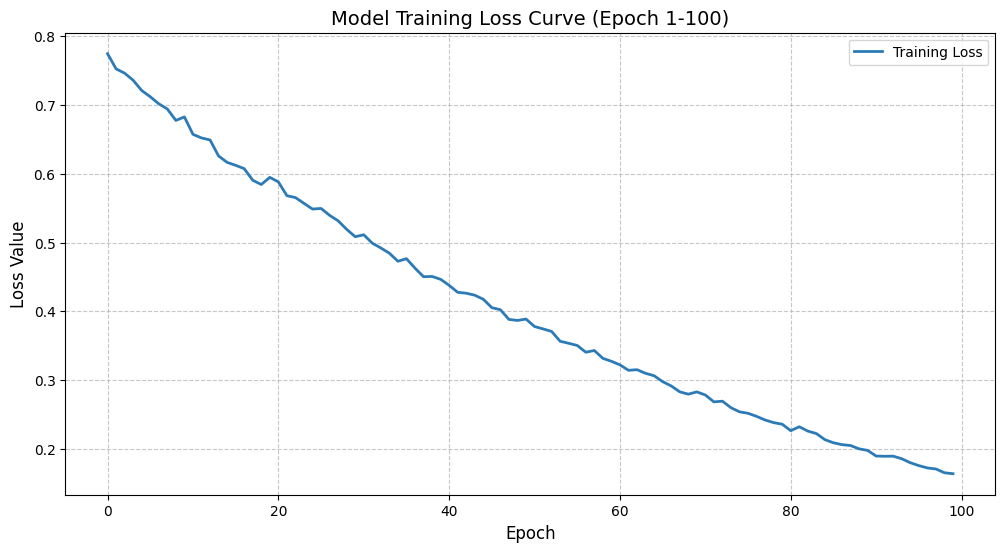

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(losses, color='#2c7bb6', linewidth=2, label='Training Loss')
plt.title("Model Training Loss Curve (Epoch 1-100)", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Value", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.show()

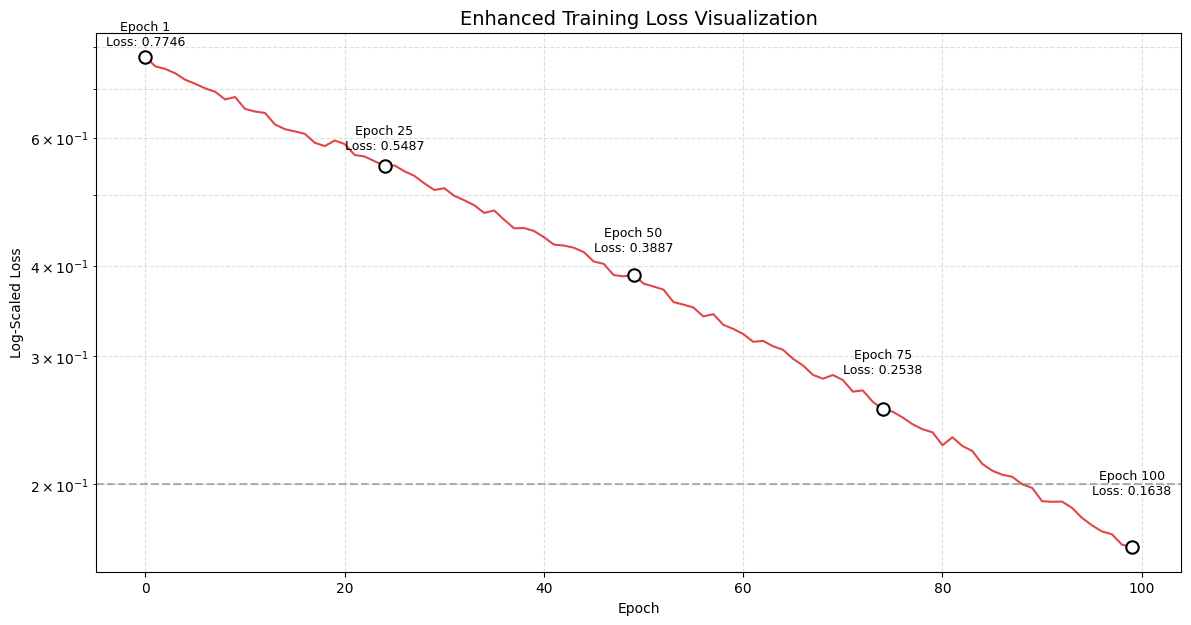

In [51]:
import numpy as np

plt.figure(figsize=(14, 7))
plt.plot(losses, color='#d7191c', linewidth=1.5, alpha=0.8)

# 标记关键点
key_epochs = [1, 25, 50, 75, 100]
for epoch in key_epochs:
    plt.scatter(epoch-1, losses[epoch-1], s=80, 
                edgecolors='black', facecolor='white', 
                linewidth=1.5, zorder=3)
    plt.text(epoch-1, losses[epoch-1]+0.03, 
             f'Epoch {epoch}\nLoss: {losses[epoch-1]:.4f}',
             ha='center', fontsize=9)

plt.axhline(y=0.2, color='gray', linestyle='--', alpha=0.6)
plt.yscale('log')  # 对数坐标更清晰展示后期变化
plt.title("Enhanced Training Loss Visualization", fontsize=14)
plt.xlabel("Epoch")
plt.ylabel("Log-Scaled Loss")
plt.grid(True, which="both", ls="--", alpha=0.4)
plt.show()

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.lineplot(data=Loss, linewidth=2, color='royalblue')
plt.title("Training Loss Trend", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss Value", fontsize=12)
plt.grid(True, alpha=0.3)
sns.despine()  # 移除上方和右侧边框
plt.show()

NameError: name 'Loss' is not defined

<Figure size 1000x500 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Example data for epochs and corresponding losses
epochs = list(range(1, 101))  # Assuming 100 epochsimport matplotlib.pyplot as plt

# Example data for epochs and corresponding losses
epochs = list(range(1, 101))  # Assuming 100 epochs

In [45]:
# -------------------- 6. 评估 --------------------
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for images, texts, labels in test_loader:
        images, texts, labels = images.to(device), texts.to(device), labels.to(device)
        outputs = model(images, texts)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=encoder.classes_))



                 precision    recall  f1-score   support

 1(interactive)       0.25      0.14      0.18        42
  2(expressive)       0.46      0.50      0.48       250
3(entertaining)       0.50      0.44      0.47       299
   4(offensive)       0.47      0.55      0.51       202
       5(other)       0.00      0.00      0.00         4

       accuracy                           0.47       797
      macro avg       0.34      0.33      0.33       797
   weighted avg       0.47      0.47      0.47       797



c:\Users\14122\anaconda3\envs\janus_pro\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\14122\anaconda3\envs\janus_pro\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\14122\anaconda3\envs\janus_pro\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [ ]:
# -------------------- 7. 推理函数 --------------------
def predict(image_path, text, model, preprocess, encoder):
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    text_tensor = clip.tokenize([f"Tone: {text}"]).to(device)
    
    with torch.no_grad():
        logits = model(image, text_tensor)
        probs = torch.softmax(logits, dim=1)
    
    return {
        "class": encoder.inverse_transform([logits.argmax().item()])[0],
        "confidence": round(probs.max().item(), 4)
    }

# 示例调用
result = predict("test_image.jpg", "sarcastic", model, preprocess, encoder)
print(result)  # 输出: {'class': 'entertaining', 'confidence': 0.9567}